In [1]:
import tensorflow as tf
import os

tf.__version__ 

2023-06-17 17:00:35.263761: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-17 17:00:35.607891: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-17 17:00:35.607915: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-17 17:00:36.688360: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

'2.11.0'

In [2]:
# Avoid OOM errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices("GPU")

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


2023-06-17 17:00:38.137496: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-17 17:00:38.137870: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-17 17:00:38.137940: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (breno): /proc/driver/nvidia/version does not exist


In [3]:
# Remove dodgy images
import cv2
import imghdr
import matplotlib.pyplot as plt

data_dir = "img_data"

In [4]:
# Image extensions
image_exts = ['jpeg','jpg', 'bmp', 'png', 'gif']

# Exclude bad images
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Corrupt JPEG data: 6191 extraneous bytes before marker 0xc4


In [5]:
import numpy as np 
import matplotlib.pyplot as plt

data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 8444 files belonging to 2 classes.


2023-06-17 17:01:55.379874: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


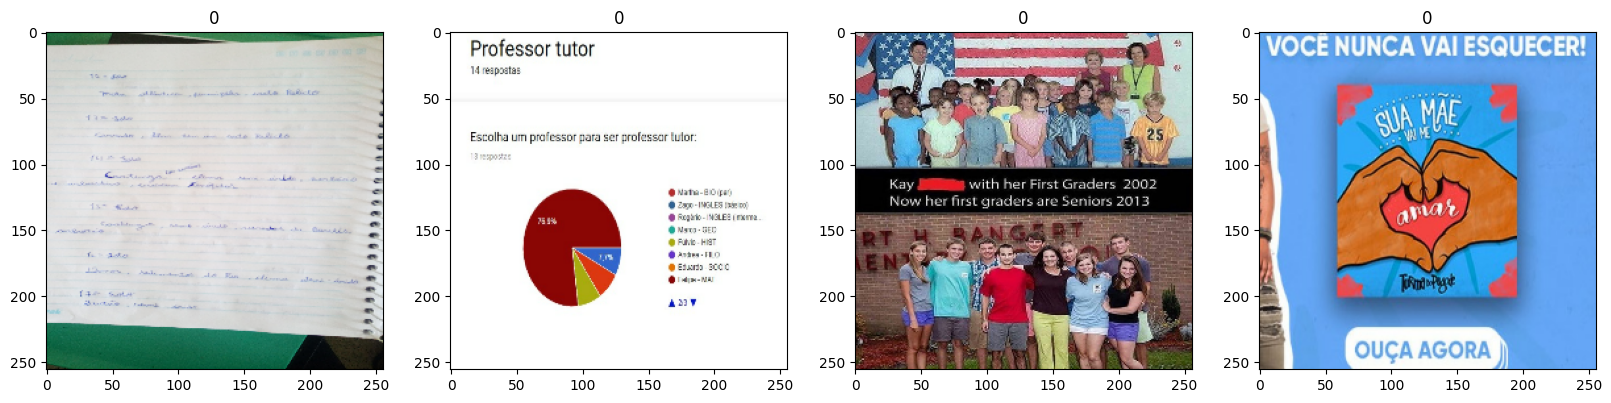

In [6]:
# Creat an iterator
data_iterator = data.as_numpy_iterator()

# Get another batch from the iterator
batch = data_iterator.next()

# Plot the images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])



## Preprocess Data :D 


In [7]:
# Normalize the pixels values
data = data.map(lambda x, y: (x / 255, y))

# Get the iterator 
scaled_iterator = data.as_numpy_iterator()

# Get a batch
batch = scaled_iterator.next()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


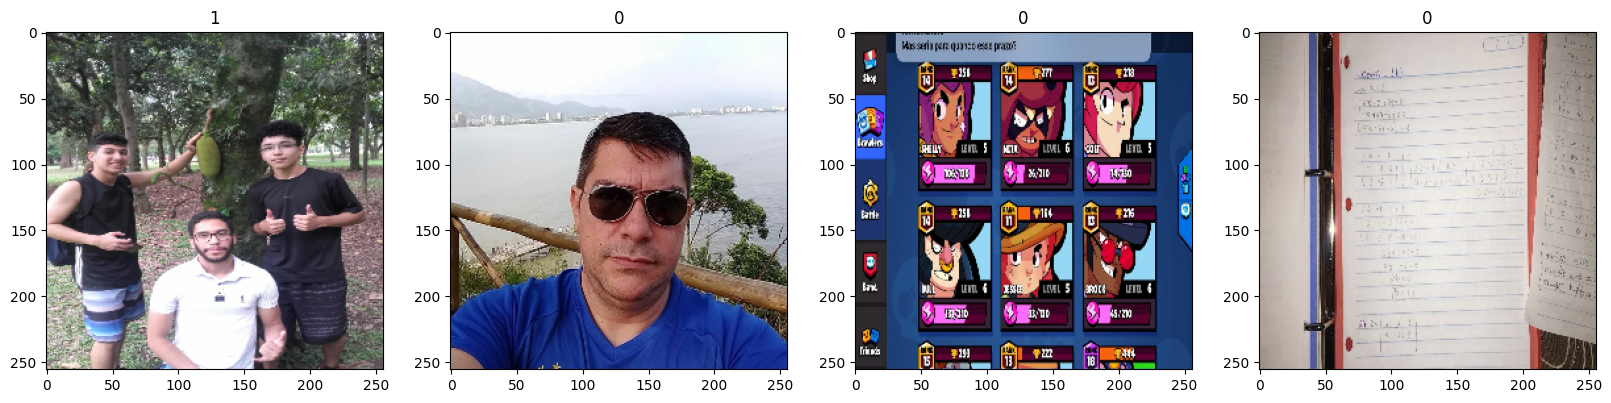

In [8]:
# Plot it
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [9]:
# Split the data
train_size = int(len(data)*.7)
val_size = int(len(data)*.2) + 1
test_size = int(len(data)*.1) + 1

# Get the data
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)


## Deep Model


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [11]:
# Create the model :)

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [12]:
model.compile("adam", loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [14]:
log_dir = "logs"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

hist = model.fit(train, epochs=7, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/7


 18/184 [=>............................] - ETA: 2:02 - loss: 0.6201 - accuracy: 0.9010

Corrupt JPEG data: 6191 extraneous bytes before marker 0xc4


184/184 [==============================] - ETA: 0s - loss: 0.3244 - accuracy: 0.8991

Corrupt JPEG data: 6191 extraneous bytes before marker 0xc4


184/184 [==============================] - 160s 863ms/step - loss: 0.3244 - accuracy: 0.8991 - val_loss: 0.2386 - val_accuracy: 0.9039
Epoch 2/7
  8/184 [>.............................] - ETA: 2:12 - loss: 0.2732 - accuracy: 0.9023

Corrupt JPEG data: 6191 extraneous bytes before marker 0xc4


184/184 [==============================] - ETA: 0s - loss: 0.2495 - accuracy: 0.9022

Corrupt JPEG data: 6191 extraneous bytes before marker 0xc4


184/184 [==============================] - 150s 813ms/step - loss: 0.2495 - accuracy: 0.9022 - val_loss: 0.2230 - val_accuracy: 0.9004
Epoch 3/7
  8/184 [>.............................] - ETA: 2:09 - loss: 0.1963 - accuracy: 0.9297

Corrupt JPEG data: 6191 extraneous bytes before marker 0xc4


184/184 [==============================] - ETA: 0s - loss: 0.2065 - accuracy: 0.9117

Corrupt JPEG data: 6191 extraneous bytes before marker 0xc4


184/184 [==============================] - 149s 804ms/step - loss: 0.2065 - accuracy: 0.9117 - val_loss: 0.2107 - val_accuracy: 0.8945
Epoch 4/7
  7/184 [>.............................] - ETA: 2:08 - loss: 0.1509 - accuracy: 0.9464

Corrupt JPEG data: 6191 extraneous bytes before marker 0xc4


184/184 [==============================] - ETA: 0s - loss: 0.1737 - accuracy: 0.9295

Corrupt JPEG data: 6191 extraneous bytes before marker 0xc4


184/184 [==============================] - 141s 756ms/step - loss: 0.1737 - accuracy: 0.9295 - val_loss: 0.1989 - val_accuracy: 0.9133
Epoch 5/7
  8/184 [>.............................] - ETA: 2:03 - loss: 0.1249 - accuracy: 0.9492

Corrupt JPEG data: 6191 extraneous bytes before marker 0xc4


184/184 [==============================] - ETA: 0s - loss: 0.1341 - accuracy: 0.9440

Corrupt JPEG data: 6191 extraneous bytes before marker 0xc4


184/184 [==============================] - 143s 774ms/step - loss: 0.1341 - accuracy: 0.9440 - val_loss: 0.2240 - val_accuracy: 0.9092
Epoch 6/7
  8/184 [>.............................] - ETA: 2:02 - loss: 0.1115 - accuracy: 0.9609

Corrupt JPEG data: 6191 extraneous bytes before marker 0xc4


184/184 [==============================] - ETA: 0s - loss: 0.1019 - accuracy: 0.9611

Corrupt JPEG data: 6191 extraneous bytes before marker 0xc4


184/184 [==============================] - 142s 768ms/step - loss: 0.1019 - accuracy: 0.9611 - val_loss: 0.3175 - val_accuracy: 0.9175
Epoch 7/7
  8/184 [>.............................] - ETA: 1:59 - loss: 0.0443 - accuracy: 0.9883

Corrupt JPEG data: 6191 extraneous bytes before marker 0xc4


184/184 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 0.9737

Corrupt JPEG data: 6191 extraneous bytes before marker 0xc4


184/184 [==============================] - 149s 805ms/step - loss: 0.0766 - accuracy: 0.9737 - val_loss: 0.3939 - val_accuracy: 0.9157


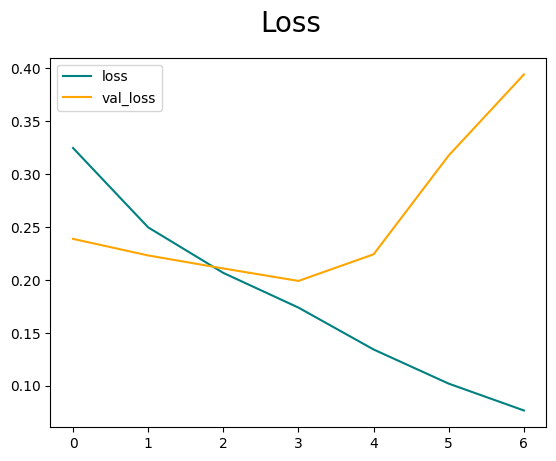

In [15]:
fig = plt.figure()

plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

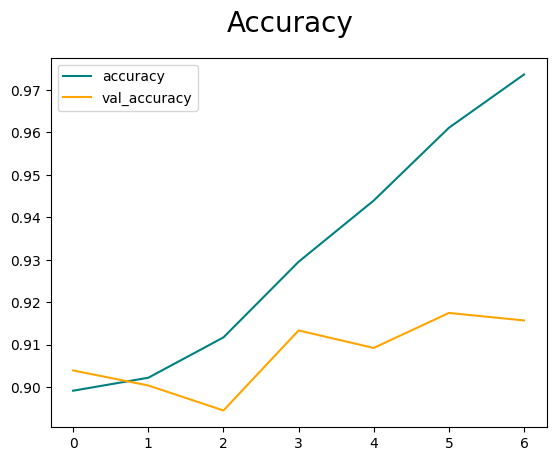

In [16]:
fig = plt.figure()

plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluate Performance

In [17]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [18]:
# Instantiate the metrics
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [19]:
# Use the test data
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f"Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}")


Corrupt JPEG data: 6191 extraneous bytes before marker 0xc4


1/1 [==============================] - 0s 177ms/step
Precision: 0.5, Recall: 0.2235294133424759, Accuracy: 0.9011628031730652


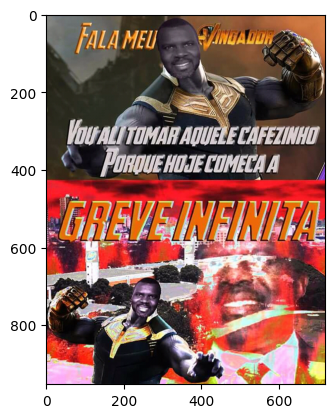

In [28]:
# Test the model
import cv2

img = cv2.imread(r"/home/breno/codes/data-science/img_data/garbage/IMG-20180512-WA0026.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

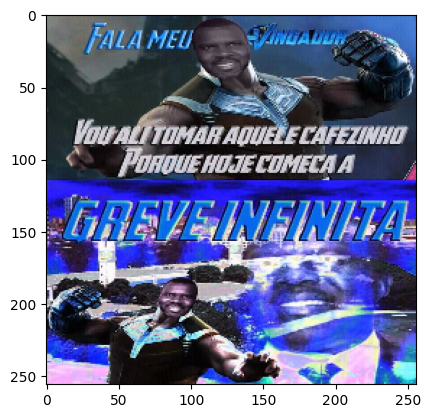

In [29]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))

In [30]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 29ms/step


array([[5.7318744e-18]], dtype=float32)

In [31]:


if yhat > 0.5:
    print("This image is a memory")
else:
    print("This image is garbage")

This image is garbage


## Save this model


In [34]:
from tensorflow.keras.models import load_model

# Save it :)
model.save(os.path.join('models', 'MemoryGarbageModelv1.h5'))

In [35]:
# Load model :)
new_model = load_model(os.path.join('models', 'MemoryGarbageModelv1.h5'))

yhat = new_model.predict(np.expand_dims(resize/255, 0))

if yhat > 0.5:
    print("This image is a memory")
else:
    print("This image is garbage")

1/1 [==============================] - 0s 77ms/step
This image is a garbage
